<a href="https://colab.research.google.com/github/kothawadegs/Deep-Learning/blob/master/S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My Drive/TSAI_EVA_4.0/S11

/content/gdrive/My Drive/TSAI_EVA_4.0/S11


In [4]:
#!pip install albumentations==0.4.5

# Load standard packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.customnet_cifar import NetCifar10
from train import train
from test import test
from results import plot_images, plot_graph
from utils import *
from gradcam.visualize import VisualizeCam
from lr_test.lr_range_test import LRRangeFinder
from lr_test.lr_cycle_plot import LRCyclePlot

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
# Setting seed and model configuration
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 512,
  'dropout': 0,
  'epochs': 24,
  'l1_decay': 2e-06,
  'l2_decay': 0.0006,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


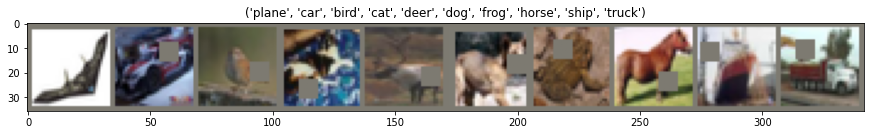

In [6]:
#loading, preprocessing the cifar10 data
data = DataEngine(args)
data.show_samples()

In [7]:
#model and summary
device = which_device()
model = NetCifar10().to(device)
show_model_summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
        LayerBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,456
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,


Learning rate search finished. See the graph with {finder_name}.plot()


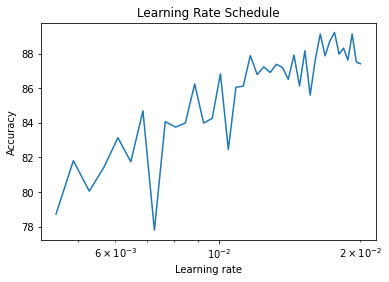

In [8]:
#LR finder(learning rate and evaluation cost)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-4, end_lr=0.02,
                     epochs=50, step_mode="linear")
lr_finder.plot(metric='acc', skip_start=10, skip_end=0)
lr_finder.reset()

In [9]:
best_acc = lr_finder.best_acc
best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))

Best Accuracy: 89.22
Best Learning Rate: 0.017616061224489797


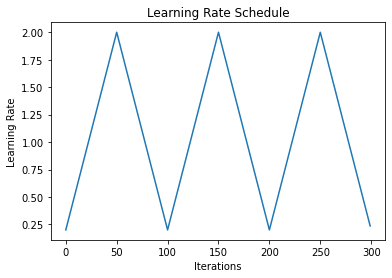

<Figure size 432x288 with 0 Axes>

In [10]:
#Plot of LR cycle(Cyclic triangle)
lrplt = LRCyclePlot({})
lrplt("lr_cycle_plot_test.png")

In [11]:
# Model training and testing
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
                       epochs=args.epochs, div_factor=10, final_div_factor=1,
                       pct_start=5/args.epochs, anneal_strategy="linear")

test_losses, train_losses, test_accs, train_accs = [], [], [], []
misclassified_imgs, correct_imgs = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(args.epochs):
      lr_trend.append(optimizer.param_groups[0]['lr'])
      print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs, scheduler)
      test(model, device, data.test_loader, criterion, data.classes, test_losses,
           test_accs, misclassified_imgs, correct_imgs, epoch==args.epochs-1)

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001762)


L2_loss=276.368 L1_loss=74330.266 Loss=1.53057 Batch_id=97 Accuracy=40.95: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.3519, Accuracy: 5207/10000 (52.07%)

EPOCH: 2 (LR: 0.004939)


L2_loss=276.959 L1_loss=74387.258 Loss=1.32818 Batch_id=97 Accuracy=59.81: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0467, Accuracy: 6389/10000 (63.89%)

EPOCH: 3 (LR: 0.008116)


L2_loss=277.605 L1_loss=74459.961 Loss=1.14164 Batch_id=97 Accuracy=69.72: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8080, Accuracy: 7263/10000 (72.63%)

EPOCH: 4 (LR: 0.011294)


L2_loss=278.247 L1_loss=74537.188 Loss=1.02802 Batch_id=97 Accuracy=74.57: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 1.0229, Accuracy: 6839/10000 (68.39%)

EPOCH: 5 (LR: 0.014471)


L2_loss=278.889 L1_loss=74630.508 Loss=1.06270 Batch_id=97 Accuracy=76.99: 100%|██████████| 98/98 [00:29<00:00,  3.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.8358, Accuracy: 7480/10000 (74.80%)

EPOCH: 6 (LR: 0.017608)


L2_loss=279.390 L1_loss=74691.328 Loss=0.73376 Batch_id=97 Accuracy=80.79: 100%|██████████| 98/98 [00:30<00:00,  3.22it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7271, Accuracy: 7701/10000 (77.01%)

EPOCH: 7 (LR: 0.016773)


L2_loss=279.819 L1_loss=74745.008 Loss=0.82397 Batch_id=97 Accuracy=82.41: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.7261, Accuracy: 7681/10000 (76.81%)

EPOCH: 8 (LR: 0.015939)


L2_loss=280.231 L1_loss=74795.445 Loss=0.80933 Batch_id=97 Accuracy=84.01: 100%|██████████| 98/98 [00:30<00:00,  3.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.6557, Accuracy: 8025/10000 (80.25%)

EPOCH: 9 (LR: 0.015104)


L2_loss=280.553 L1_loss=74822.180 Loss=0.74472 Batch_id=97 Accuracy=85.77: 100%|██████████| 98/98 [00:30<00:00,  3.23it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4875, Accuracy: 8456/10000 (84.56%)

EPOCH: 10 (LR: 0.014270)


L2_loss=280.839 L1_loss=74841.734 Loss=0.65520 Batch_id=97 Accuracy=87.24: 100%|██████████| 98/98 [00:29<00:00,  3.30it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4347, Accuracy: 8606/10000 (86.06%)

EPOCH: 11 (LR: 0.013435)


L2_loss=281.095 L1_loss=74853.359 Loss=0.67210 Batch_id=97 Accuracy=88.67: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.5036, Accuracy: 8486/10000 (84.86%)

EPOCH: 12 (LR: 0.012601)


L2_loss=281.317 L1_loss=74862.914 Loss=0.55599 Batch_id=97 Accuracy=89.68: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4164, Accuracy: 8684/10000 (86.84%)

EPOCH: 13 (LR: 0.011766)


L2_loss=281.490 L1_loss=74855.789 Loss=0.58042 Batch_id=97 Accuracy=90.77: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4548, Accuracy: 8621/10000 (86.21%)

EPOCH: 14 (LR: 0.010932)


L2_loss=281.651 L1_loss=74843.828 Loss=0.59484 Batch_id=97 Accuracy=91.25: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3883, Accuracy: 8763/10000 (87.63%)

EPOCH: 15 (LR: 0.010098)


L2_loss=281.791 L1_loss=74827.898 Loss=0.52252 Batch_id=97 Accuracy=92.17: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.4458, Accuracy: 8601/10000 (86.01%)

EPOCH: 16 (LR: 0.009263)


L2_loss=281.890 L1_loss=74805.125 Loss=0.51810 Batch_id=97 Accuracy=92.49: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3746, Accuracy: 8830/10000 (88.30%)

EPOCH: 17 (LR: 0.008429)


L2_loss=281.981 L1_loss=74775.453 Loss=0.53915 Batch_id=97 Accuracy=93.26: 100%|██████████| 98/98 [00:28<00:00,  3.38it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3678, Accuracy: 8831/10000 (88.31%)

EPOCH: 18 (LR: 0.007594)


L2_loss=282.047 L1_loss=74736.312 Loss=0.51608 Batch_id=97 Accuracy=93.81: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3495, Accuracy: 8910/10000 (89.10%)

EPOCH: 19 (LR: 0.006760)


L2_loss=282.098 L1_loss=74695.453 Loss=0.46011 Batch_id=97 Accuracy=94.15: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3568, Accuracy: 8910/10000 (89.10%)

EPOCH: 20 (LR: 0.005925)


L2_loss=282.109 L1_loss=74642.500 Loss=0.47119 Batch_id=97 Accuracy=95.14: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3649, Accuracy: 8930/10000 (89.30%)

EPOCH: 21 (LR: 0.005091)


L2_loss=282.105 L1_loss=74586.391 Loss=0.44189 Batch_id=97 Accuracy=95.55: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3445, Accuracy: 8982/10000 (89.82%)

EPOCH: 22 (LR: 0.004256)


L2_loss=282.080 L1_loss=74527.297 Loss=0.39126 Batch_id=97 Accuracy=95.95: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.3606, Accuracy: 8938/10000 (89.38%)

EPOCH: 23 (LR: 0.003422)


L2_loss=282.045 L1_loss=74469.227 Loss=0.41229 Batch_id=97 Accuracy=96.40: 100%|██████████| 98/98 [00:28<00:00,  3.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 84 %
Accuracy of  deer : 85 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 90 %
Accuracy of truck : 85 %

Test set: Average loss: 0.3337, Accuracy: 9024/10000 (90.24%)

EPOCH: 24 (LR: 0.002588)


L2_loss=282.001 L1_loss=74415.688 Loss=0.40050 Batch_id=97 Accuracy=96.81: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Accuracy of plane : 80 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 58 %
Accuracy of  deer : 85 %
Accuracy of   dog : 75 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 75 %

Test set: Average loss: 0.3228, Accuracy: 9037/10000 (90.37%)



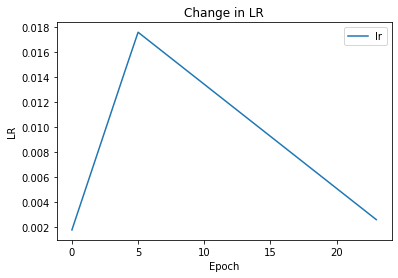

In [12]:
# Learning rate schedule plot
plt_data = {
    "lr": lr_trend,
}
plot_graph(plt_data, "LR")

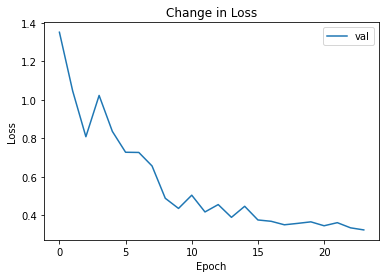

In [13]:
#plotting validation loss
plt_data = {
    "val": test_losses,
}
plot_graph(plt_data, "Loss")

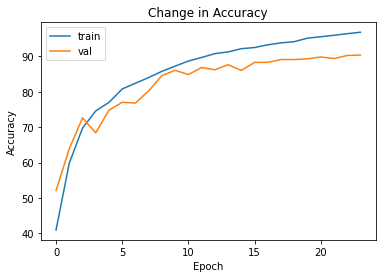

In [14]:
#Validation accuracy plot
plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

In [0]:
# GradCAM Visualtion
target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

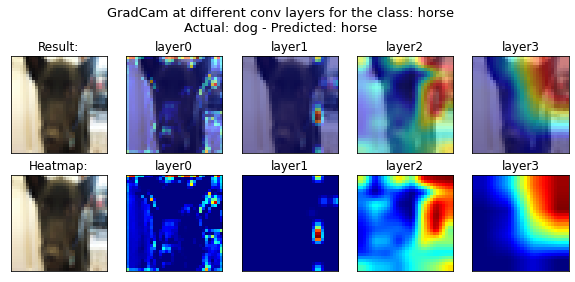

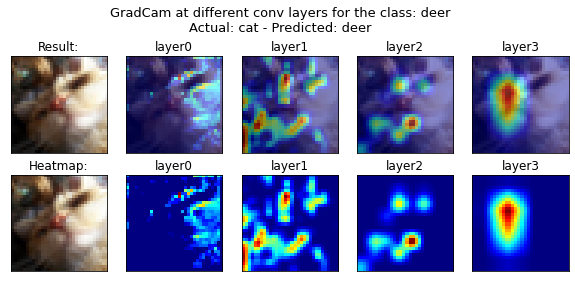

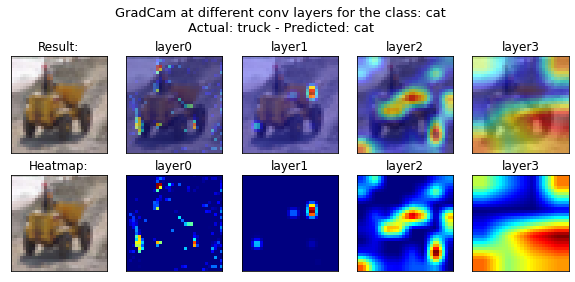

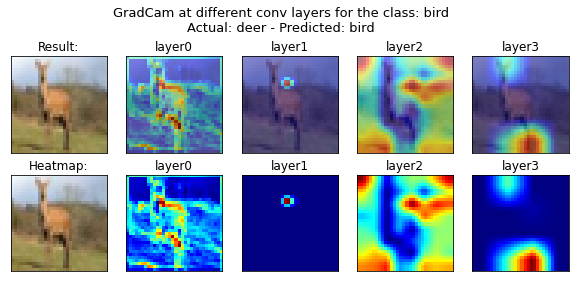

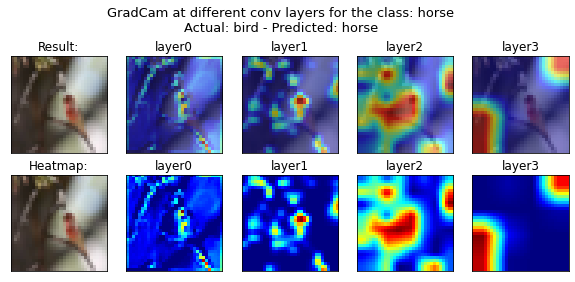

In [16]:
#Layer wise GradCAM misclassified images visualization
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")